# Ride Hailing Demand Prediction
### Berke Kavak

Ride hailing can be defined as a service that matches drivers with customers through online platforms. The aim of this notebook is to guide the drivers to the locations with higher expected demand at given time and location **using clustering and regression**

* The data is approximately 630000 rows of synthetic ride demand data which belongs to March 2022

* To solve this, I applied the following strategies:

**1 - Data exploration, analysis, preprocessing**

* Observing data to see whether there are empty or malformed instances
* Feature engineering
* Data visualization
* Outlier detection

**2 - Identifying sub-regions using clustering** 

* Split the data into train and test
* Determining the optimal number of clusters
* Training a K-Means model

**3 - Building a regression model to predict the demand based on time and location**

* Aggregating the data based on cluster and time
* Comparing several regressors and choosing the most suitable one

**4 - Writing a script to simulate real-world application by guiding drivers to high demand areas**

* Generating a random coordinate in Tallinn, Estonia and a timestamp
* Preparing the data for our Regression Model
* Predicting the demand at each clusters to guide the driver
* Output a score for each region (cluster) considering the given random coordinate and it's distance to other cluster centers

**5 - Results and Future Work**

* Results of our script
* Possible features that can be added
* Deployment discussions
* A/B test to measure the effectiveness of our approach

In [1]:
# Import required libraries for the project

import os
import random
import sys
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from PIL import Image, ImageDraw, ImageFont
from scipy import stats
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score, roc_auc_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from staticmap import CircleMarker, StaticMap
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seeds to ensure reproducability:

random.seed(42)
np.random.seed(42)

## 1. Data Preprocessing and Analysis

In [3]:
df = pd.read_csv('robotex5.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [5]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [6]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


* All of the columns are non-null

### Feature Engineering

In [7]:
# Returns the haversine distance in kilometers given two latitude and longitude pairs.
# It is the angular distance between two points on the surface of a sphere.

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371.0
    return c * r

df['distance'] = df.apply(lambda x: haversine(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis=1)

In [8]:
def preprocess(df):
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['hour'] = df['start_time'].dt.hour
    df['day'] = df['start_time'].dt.day
    df['weekday'] = df['start_time'].dt.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df = df.sort_values(by='start_time')
    return df

In [9]:
df = preprocess(df)

In [10]:
df['week_of_month'] = df['day'].apply(lambda x: x // 7 + 1) 

### Data Visualization

* Observing the patterns in the data

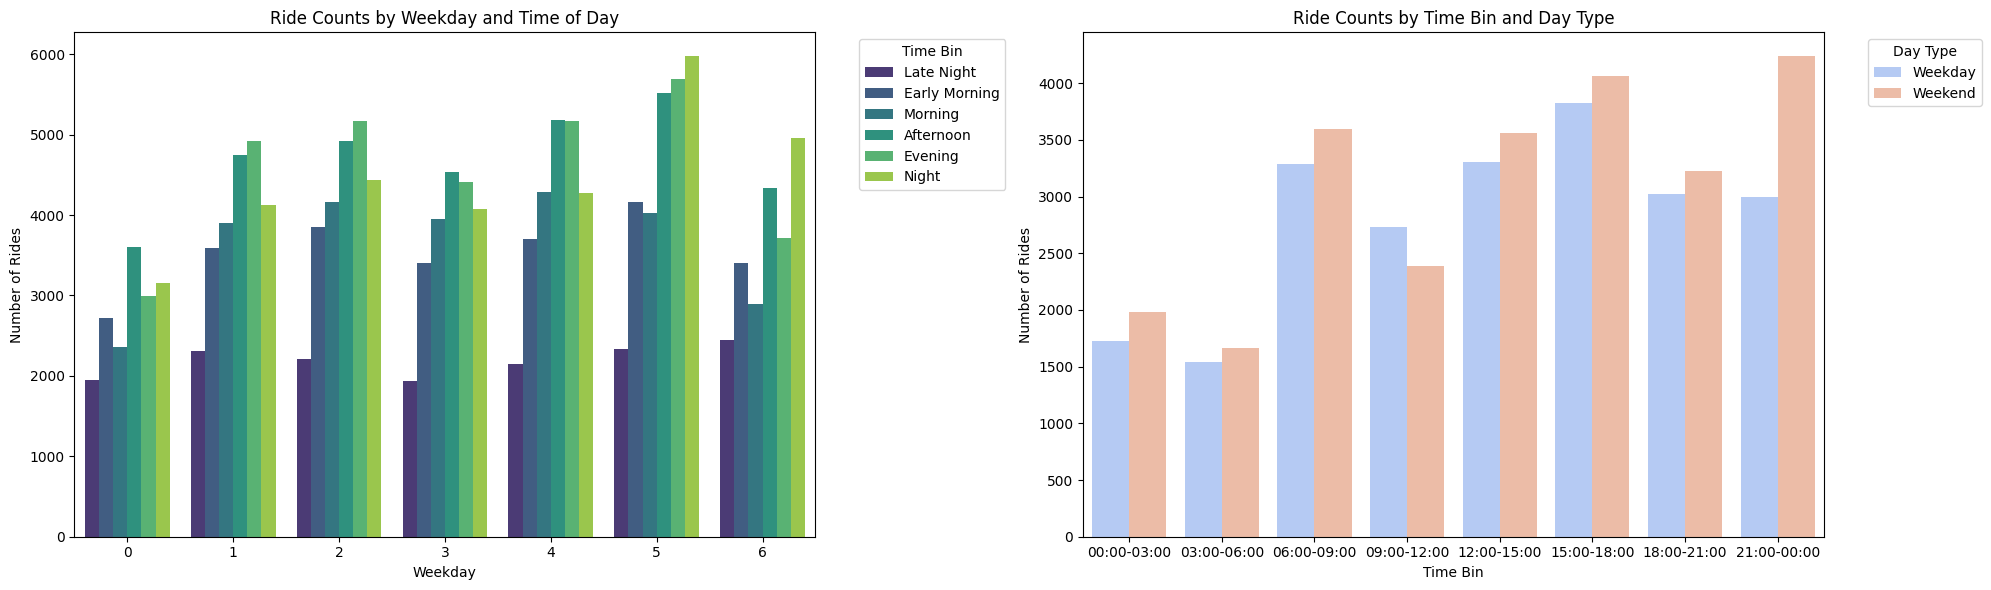

In [11]:
def time_of_day(hour):
    if 0 <= hour < 4:
        return 'Late Night'
    elif 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

def time_bins(hour):
    if 0 <= hour < 3:
        return '00:00-03:00'
    elif 3 <= hour < 6:
        return '03:00-06:00'
    elif 6 <= hour < 9:
        return '06:00-09:00'
    elif 9 <= hour < 12:
        return '09:00-12:00'
    elif 12 <= hour < 15:
        return '12:00-15:00'
    elif 15 <= hour < 18:
        return '15:00-18:00'
    elif 18 <= hour < 21:
        return '18:00-21:00'
    else:
        return '21:00-00:00'

# To see the specific patterns, let's concentrate on a full week by filtering the data:

analysis = df[df['week_of_month'] == 3].copy()

analysis.loc[:, 'time_bin'] = analysis['hour'].apply(time_bins)
analysis.loc[:, 'time_of_day'] = analysis['hour'].apply(time_of_day)
analysis.loc[:, 'day_type'] = analysis['weekday'].apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')

summarized_df_1 = analysis.groupby(['weekday', 'time_of_day']).size().reset_index(name='ride_count')
summarized_df = analysis.groupby(['weekday', 'day_type', 'time_bin']).size().reset_index(name='ride_count')

single_weekday_data = analysis[analysis['weekday'] == 3]
time_bin_summary = single_weekday_data.groupby('time_bin')['distance'].count().reset_index()


# To preserve the order, I add these:
time_frame_order = ['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

time_bin_order = ['00:00-03:00', '03:00-06:00', '06:00-09:00', '09:00-12:00', 
                  '12:00-15:00', '15:00-18:00', '18:00-21:00', '21:00-00:00']

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# First plot
sns.barplot(x='weekday', y='ride_count', hue='time_of_day', data=summarized_df_1, palette='viridis', ax=axes[0],
            hue_order=time_frame_order)
axes[0].set_title('Ride Counts by Weekday and Time of Day')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Rides')
axes[0].legend(title='Time Bin', bbox_to_anchor=(1.05, 1), loc='upper left')

# Second plot
sns.barplot(x='time_bin', y='ride_count', hue='day_type', data=summarized_df, palette='coolwarm', ax=axes[1],
            order=time_bin_order, errorbar=None)
axes[1].set_title('Ride Counts by Time Bin and Day Type')
axes[1].set_xlabel('Time Bin')
axes[1].set_ylabel('Number of Rides')
axes[1].legend(title='Day Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

* First graph categorizes the hours of the day by equal bins:

  -  *Early Morning*: 4 am - 8 am
  -  *Morning*: 8 am - 12 pm
  -  *Afternoon*: 12 pm - 16 pm
  -  *Evening*: 16 pm - 12 am
  -  *Night*: 12 am - 4 am
  -  *Late Night*:4 am - 8 am
 
* Second graph is concentrated on observing the difference between weekdays and weekend.
  
* We can see that ride-hailing demand peaks on weekend nights (20:00 to 00:00), which contrasts with the demand patterns observed on weekdays. During weekdays, the highest demand occurs in the evening. To capture this pattern, we should use the "is_weekend" as a feature in our model.
* In the second graph, weekday morning (9:00 to 12:00) demand is larger than weekend morning demand due to commuting hours as expected

* For simplicity, we will focus on building a single model since the demand patterns are similar.

In [12]:
# Set the properties to default

plt.rcdefaults()

### Outlier Detection

* To remove the outliers, I introduced distance as a feature by calculating the **haversine distance** between start and end coordinates in the previous section.

* There are some anomalies with the distance traveled

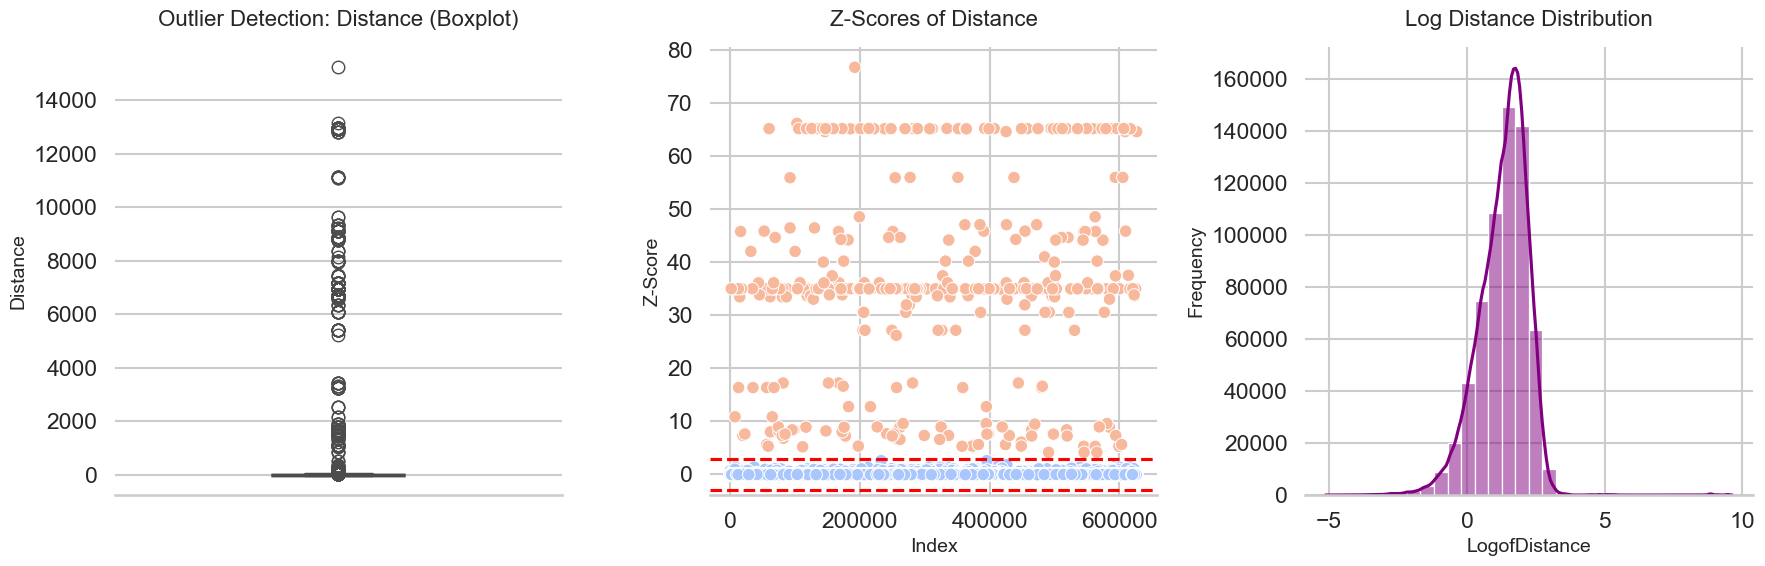

In [13]:
df['z_score'] = stats.zscore(df['distance'])
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(18, 6))

# First subplot
plt.subplot(1, 3, 1)
sns.boxplot(y=df['distance'], width=0.3, linewidth=2.5)
plt.title('Outlier Detection: Distance (Boxplot)', fontsize=16, pad=15)
plt.ylabel('Distance', fontsize=14)
plt.xlabel('')
sns.despine(left=True)

# Second subplot
plt.subplot(1, 3, 2)
sns.scatterplot(x=df.index, y=df['z_score'], palette="coolwarm", hue=(df['z_score'] > 3) | (df['z_score'] < -3), legend=False)
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.title('Z-Scores of Distance', fontsize=16, pad=15)
plt.ylabel('Z-Score', fontsize=14)
plt.xlabel('Index', fontsize=14)
sns.despine(left=True)

# Third subplot
plt.subplot(1, 3, 3)
sns.histplot(df['distance'].apply(lambda x: np.log(x)), kde=True, color='purple', bins=30)
plt.title('Log Distance Distribution', fontsize=16, pad=15)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('LogofDistance', fontsize=14)
sns.despine(left=True)

plt.tight_layout()
plt.show()

When using the Isolation Forest, I decreased the contamination parameter to make sure that I do not eliminate any information that could be useful for the modeling.

In [14]:
def detect_outliers(df, features, threshold=3):
    df = df.copy()
    iso_forest = IsolationForest(contamination=0.001, random_state=42)
    df['isof_outlier'] = iso_forest.fit_predict(df[features])
    df['isof_outlier'] = df['isof_outlier'].apply(lambda x: 1 if x == -1 else 0)  # Convert to 0/1
    return df

df = detect_outliers(df, features = ['distance'])

In [15]:
print(df[df['isof_outlier'] == 0].shape)

df[df['isof_outlier'] == 0]['distance'].sort_values(ascending=False)

(626591, 14)


434021    94.822293
448520    94.822293
360624    94.432753
418356    94.432753
110314    94.432753
            ...    
355441     0.006119
51819      0.006119
525227     0.005931
82744      0.005887
598759     0.005887
Name: distance, Length: 626591, dtype: float64

* After using Isolation Forest, maximum distance traveled decreased from ~15000 kms to ~95 kms

In [16]:
df = df[df['isof_outlier'] == 0]

## 2. Identifying sub-regions using Clustering

### Determine the Optimal Number of Clusters

* The Elbow Method is a graphical method (heuristic) for finding the optimal K value in a k-means clustering algorithm which shows the within-cluster-sum-of-square (WCSS) values
 
* Determining optimal k depends on several factors, it is also depends on business decisions, so I looked at the Silhouette and Elbow Scores together to determine the number of clusters

In [17]:
# Let's divide the data into training and validation. Here I wanted to use first 3 weeks as training and the last week as test.

train_data = df[df['day'] <= 21]
test_data = df[df['day'] > 21]

coords_train = train_data[['start_lat', 'start_lng']]

Calculating Silhouette Scores: 100%|████████████| 20/20 [05:27<00:00, 16.38s/it]


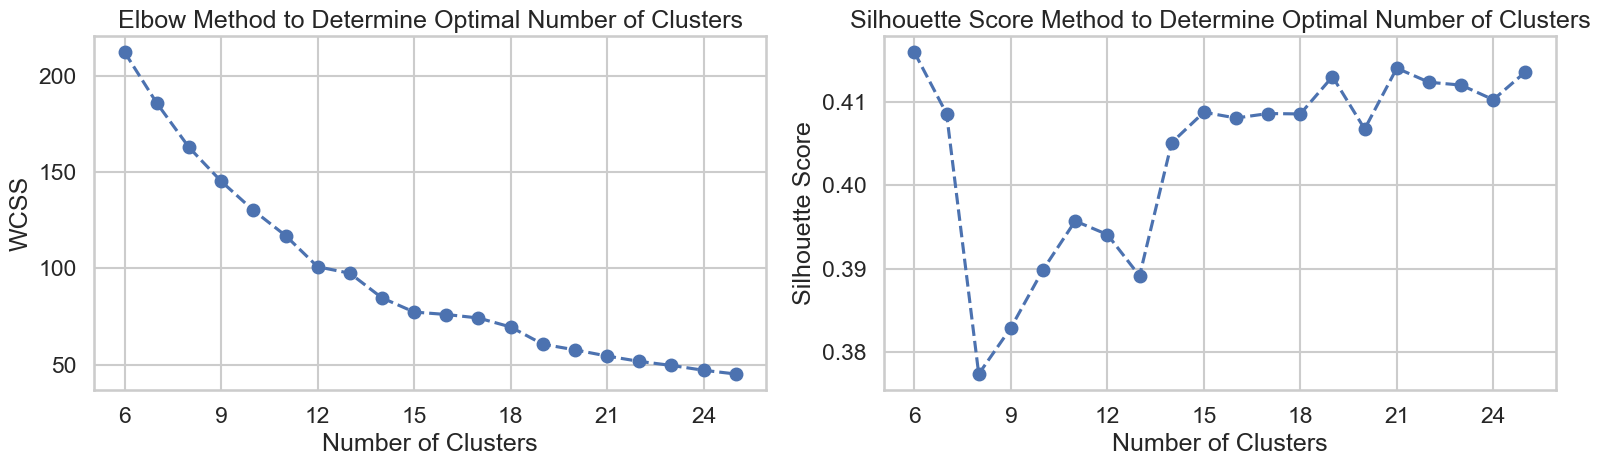

In [18]:
def plot_elbow_and_silhouette(train_data, max_clusters=25, sample_fraction=0.2):
    wcss = []
    silhouette_scores = []

    # WCSS calculation
    for n_clusters in range(6, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(train_data[['start_lat', 'start_lng']])
        wcss.append(kmeans.inertia_)
    
    # I used a sample of weekday and weekend data to calculate the silhouette score
    sampled_data = train_data[(train_data['week_of_month'] == 3) & ((train_data['weekday'] == 4) | (train_data['weekday'] == 5))]
    
    for n_clusters in tqdm(range(6, max_clusters + 1), desc="Calculating Silhouette Scores"):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(sampled_data[['start_lat', 'start_lng']])
        silhouette_avg = silhouette_score(sampled_data[['start_lat', 'start_lng']], cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Elbow
    axes[0].plot(range(6, max_clusters + 1), wcss, marker='o', linestyle='--')
    axes[0].set_title('Elbow Method to Determine Optimal Number of Clusters')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('WCSS')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integer values

    # Plot Silhouette
    axes[1].plot(range(6, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
    axes[1].set_title('Silhouette Score Method to Determine Optimal Number of Clusters')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integer values

    plt.tight_layout()
    plt.show()

plot_elbow_and_silhouette(train_data)

* According to silhouette score and desired number of regions, I decided to select 19 as the number of clusters, since it has a high silhouette value and this k would be more suitable for this problem.

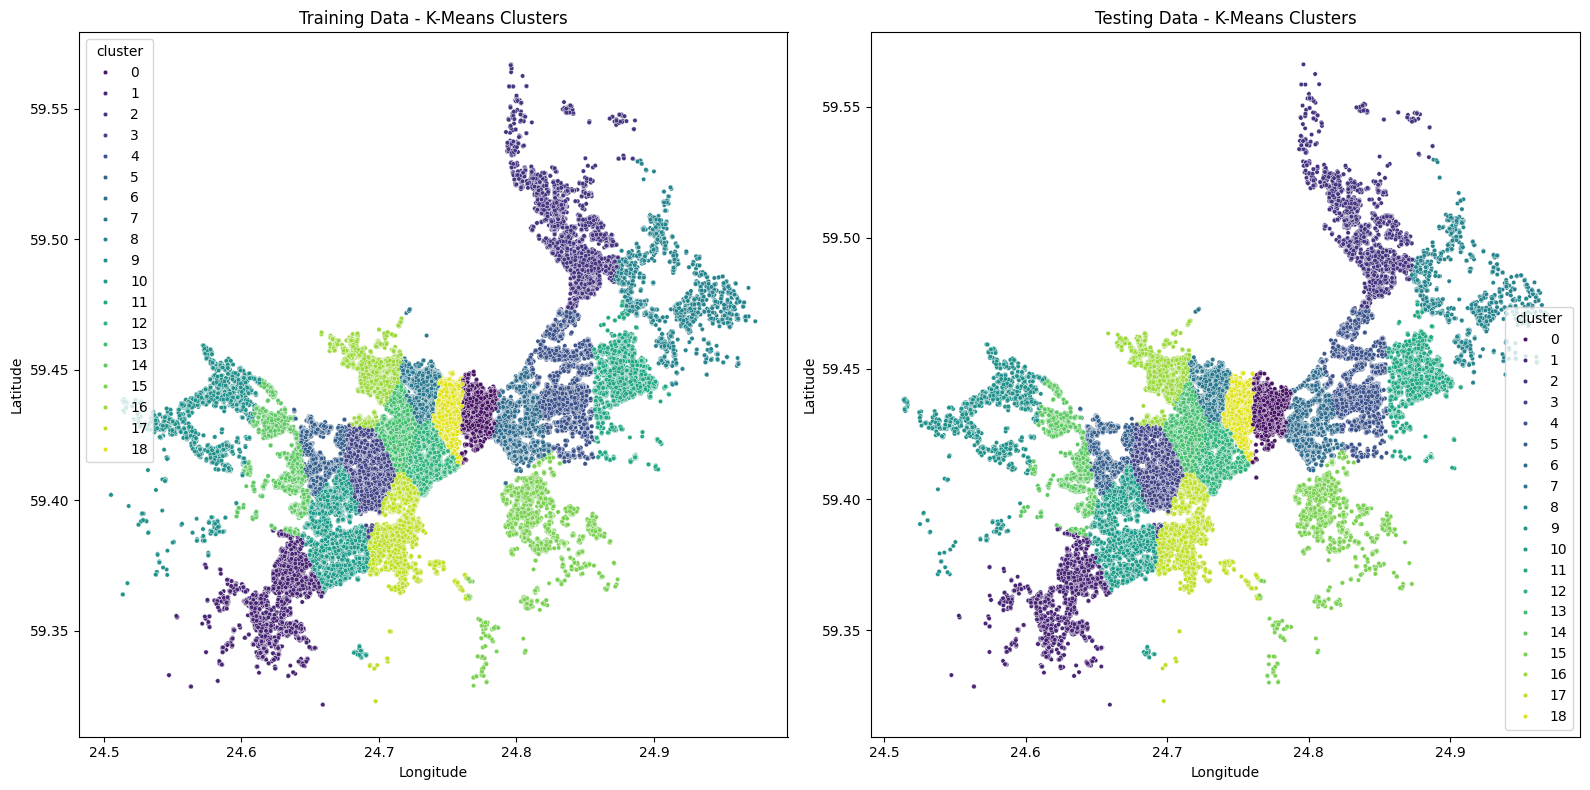

In [19]:
# This sampling is for reporting the silhouette score
plt.rcdefaults()

train_data_sample = train_data[(train_data['week_of_month'] == 3) & ((train_data['weekday'] == 4) | (train_data['weekday'] == 5))]
test_data_sample = test_data[(test_data['weekday'] == 4) | (train_data['weekday'] == 5)]


def fit_and_predict_kmeans(train_data, test_data, n_clusters, title):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit K-Means on the training data, predict for the test set.
    train_data.loc[:, 'cluster'] = kmeans.fit_predict(train_data[['start_lat', 'start_lng']])
    test_data.loc[:, 'cluster'] = kmeans.predict(test_data[['start_lat', 'start_lng']])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x='start_lng', y='start_lat', hue='cluster', data=train_data,
        palette=sns.color_palette('viridis', n_clusters), legend='full', s=10
    )
    plt.title(f'Training Data - {title}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x='start_lng', y='start_lat', hue='cluster', data=test_data,
        palette=sns.color_palette('viridis', n_clusters), legend='full', s=10
    )
    plt.title(f'Testing Data - {title}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
    return kmeans

kmeans = fit_and_predict_kmeans(train_data, test_data, 19, "K-Means Clusters")

#### Let's further examine the cluster data by filtering for a random day and hour

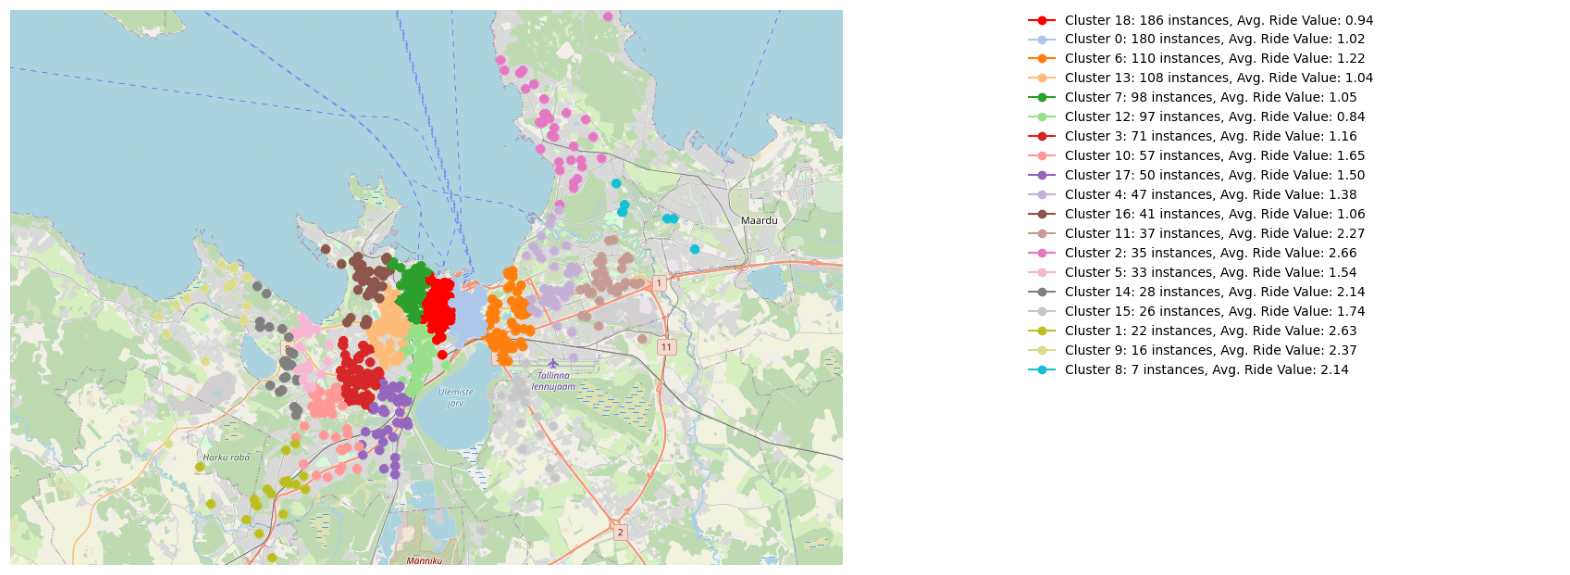

In [20]:
example_hour = train_data[(train_data['day'] == 17) & (train_data['hour'] == 15)]

map_width, map_height = 900, 600
m = StaticMap(map_width, map_height)

cluster_sizes = example_hour['cluster'].value_counts()
sorted_clusters = cluster_sizes.index.tolist()
num_clusters = len(sorted_clusters)

colors = plt.get_cmap('tab20')
color_map = {cluster: colors(i / num_clusters) for i, cluster in enumerate(sorted_clusters)}

most_crowded_cluster = sorted_clusters[0]
color_map[most_crowded_cluster] = (1, 0, 0, 1)

average_ride_values = example_hour.groupby('cluster')['ride_value'].mean()

for idx, row in example_hour.iterrows():
    color = color_map[row['cluster']]
    color_hex = '#%02x%02x%02x' % (int(color[0]*255), int(color[1]*255), int(color[2]*255))
    marker = CircleMarker((row['start_lng'], row['start_lat']), color_hex, 10)
    m.add_marker(marker)

lat_min = example_hour['start_lat'].min()
lat_max = example_hour['start_lat'].max()
lng_min = example_hour['start_lng'].min()
lng_max = example_hour['start_lng'].max()
center_lat = (lat_min + lat_max) / 2
center_lng = (lng_min + lng_max) / 2
zoom_level = 11

image = m.render(center=(center_lng, center_lat), zoom=zoom_level)

map_image_path = 'Cluster_Map_March17_15_00.png'
image.save(map_image_path)

# Legend
fig, ax = plt.subplots(figsize=(10, 5))

for cluster in sorted_clusters:
    color = color_map[cluster]
    ax.plot([], [], marker='o', color=color, label=f'Cluster {cluster}: {cluster_sizes[cluster]} instances, Avg. Ride Value: {average_ride_values[cluster]:.2f}')
ax.legend(loc='center', frameon=False)
ax.axis('off')

legend_image_path = 'cluster_legend.png'
fig.savefig(legend_image_path, bbox_inches='tight', pad_inches=0)
plt.close(fig)

map_img = Image.open(map_image_path)
legend_img = Image.open(legend_image_path)

combined_width = map_img.width + legend_img.width
combined_height = max(map_img.height, legend_img.height)
combined_img = Image.new('RGBA', (combined_width, combined_height), (255, 255, 255, 255))

combined_img.paste(map_img, (0, 0))
combined_img.paste(legend_img, (map_img.width, 0))

combined_image_path = 'Cluster_Map_wLegend_17_March2022_15_00.png'
combined_img.save(combined_image_path)

plt.figure(figsize=(20, 12))
combined_img = plt.imread(combined_image_path)
plt.imshow(combined_img)
plt.axis('off')
plt.show()

* We can see that while the city center tends to have higher demand, the average ride value there is one of the lowest.

## 3. Train a Regression Model to predict the demand for each cluster based on a specific day and hour

* Here, I decided on how to aggregate data and the model. For each cluster and time, we are predicting the demand. 

* I aggregated the data according to cluster, weekday, hour and week of month to determine the ride count. Here is the training data after aggregations.

In [21]:
train_data.groupby(['cluster', 'weekday', 'hour', 'week_of_month'])['ride_value'].count().reset_index().rename(columns = {'ride_value':'ride_count'})

,cluster,weekday,hour,week_of_month,ride_count
0,0,0,0,2,47
1,0,0,0,3,57
2,0,0,0,4,77
3,0,0,1,2,37
4,0,0,1,3,50
...,...,...,...,...,...
9549,18,6,22,2,432
9550,18,6,22,3,438
9551,18,6,23,1,358
9552,18,6,23,2,416


* After clustering, I trained a model that will predict the demand for these regions. I used Random Forest Regressor, XGBRegressor and a basic Linear Regression. Also combined this with this a hyperparameter optimization using Grid Search to get the best model parameters.

In [22]:
# Aggregates and prepares the data for the regression model.
def aggregate_data(df):
    df = df.copy()
    df.loc[:, 'week_of_month'] = df['start_time'].dt.day // 7 + 1
    grouped = df.groupby(['cluster', 'hour', 'weekday', 'week_of_month'])['ride_value'].count().reset_index()
    grouped.columns = ['cluster', 'hour', 'weekday', 'week_of_month', 'ride_count']    
    grouped['is_weekend'] = grouped['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return grouped

# Transforms hour from integer to sin and cos to capture the relation between the hours.
def transform_hour(df):
    df.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

def train_and_evaluate(df_train, df_test, model_params):
    df_train_grouped = aggregate_data(df_train)
    df_test_grouped = aggregate_data(df_test)

    # Apply sine and cosine transformation to the hour feature
    df_train_grouped = transform_hour(df_train_grouped)
    df_test_grouped = transform_hour(df_test_grouped)

    # Select features and target for both train and test sets
    features = ['hour_sin', 'hour_cos', 'weekday', 'cluster', 'is_weekend']

    X_train = df_train_grouped[features]
    y_train = df_train_grouped['ride_count']
    X_test = df_test_grouped[features]
    y_test = df_test_grouped['ride_count']

    # One-hot encode the features
    X_train = pd.get_dummies(X_train, columns=['cluster', 'weekday'])
    X_test = pd.get_dummies(X_test, columns=['cluster', 'weekday'])

    # Ensures both train and test sets have the same dummy variables
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    best_model = None
    best_r2 = -np.inf
    best_y_pred = None
    best_model_name = None
    results = {}

    # Iterate over the models and their parameter grids
    for model_name, (model, param_grid) in model_params.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model_for_grid = grid_search.best_estimator_
        y_pred = best_model_for_grid.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} : Mean Squared Error: {mse} R2 Score: {r2} Best Params: {grid_search.best_params_}")

        results[model_name] = {
            'model': best_model_for_grid,
            'mse': mse,
            'r2': r2,
            'best_params': grid_search.best_params_
        }

        if r2 > best_r2:
            best_r2 = r2
            best_model = best_model_for_grid
            best_y_pred = y_pred
            best_model_name = model_name

    # Here, I print the feature importances for the best model if it has them
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print(f"\nBest Model: {best_model_name} - Feature Importances:")
        print(importance_df)
        results[best_model_name]['feature_importances'] = importance_df

    return best_model, best_y_pred, results, df_test_grouped, X_train, X_test, y_train, y_test

# Model parameters for GridSearchCV (hyperparameter opt.)
model_params = {
    'RandomForestRegressor': (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    ),
    'GradientBoostingRegressor': (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    ),
    'LinearRegression': (
        LinearRegression(),
        {
            'fit_intercept': [True, False]
        }
    )
}

best_model, best_y_pred, results, df_test_grouped, X_train, X_test, y_train, y_test = train_and_evaluate(train_data, test_data, model_params)

RandomForestRegressor : Mean Squared Error: 401.21364782952065 R2 Score: 0.8979336112252114 Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoostingRegressor : Mean Squared Error: 406.18350149972514 R2 Score: 0.8966693097249981 Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
LinearRegression : Mean Squared Error: 1143.4625779657613 R2 Score: 0.7091098554013643 Best Params: {'fit_intercept': True}

Best Model: RandomForestRegressor - Feature Importances:
       Feature  Importance
21  cluster_18    0.485064
1     hour_cos    0.142150
3    cluster_0    0.114497
0     hour_sin    0.089763
10   cluster_7    0.038156
15  cluster_12    0.025438
16  cluster_13    0.024726
6    cluster_3    0.017388
9    cluster_6    0.017137
22   weekday_0    0.009462
13  cluster_10    0.008971
2   is_weekend    0.008072
27   weekday_5    0.005480
28   weekday_6    0.004717
7    c

* I decided to use Random Forest Regressor with hyper parameter optimization, since it performed the best

## 4. A script that predicts the optimal region for the driver

* The script generates a coordinate in Tallinn Estonia and a timestamp. Given that timestamp, it predicts the demand on all possible clusters. Finally it suggests the driver best possible cluster and gives a score between 0 and 1 to guide the driver

* It guides the driver to high demand - low distance regions

In [23]:
def transform_hour(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

# Generates random coordinates inside of the Tallinn's bounding box
def generate_random_coordinates(lat_min, lat_max, lon_min, lon_max):
    random_lat = round(random.uniform(lat_min, lat_max), 6)
    random_lon = round(random.uniform(lon_min, lon_max), 6)
    return random_lat, random_lon

# Define the bounding box for Tallinn, Estonia
def generate_driver_data(kmeans, transform_hour):
    lat_min = 59.3950
    lat_max = 59.4900
    lon_min = 24.6450
    lon_max = 24.8300

    random_latitude, random_longitude = generate_random_coordinates(lat_min, lat_max, lon_min, lon_max)

    # Specify a specific time
    current_time = datetime(2024, 9, 1, 2, 6, 22, 199198)

    # Prepare the dataframe
    driver_df = pd.DataFrame({
        'start_time': [current_time],
        'start_lat': [random_latitude],
        'start_lng': [random_longitude],
        'hour': [current_time.hour],
        'day': [current_time.day],
        'weekday': [current_time.weekday()],
        'is_weekend': [1 if current_time.weekday() >= 5 else 0],
        'cluster': kmeans.predict([[random_latitude, random_longitude]]),
        'week_of_month': [current_time.day // 7 + 1]
    })

    driver_df = transform_hour(driver_df)
    int_columns = ['hour', 'day', 'weekday', 'is_weekend', 'cluster', 'week_of_month']
    driver_df[int_columns] = driver_df[int_columns].astype(int)
    
    return driver_df, random_latitude, random_longitude

driver_data, random_latitude, random_longitude = generate_driver_data(kmeans, transform_hour)

driver_data

,start_time,start_lat,start_lng,hour,day,weekday,is_weekend,cluster,week_of_month,hour_sin,hour_cos
0,2024-09-01 02:06:22.199198,59.455746,24.649627,2,1,6,1,5,1,0.5,0.866025


In [24]:
# Constructs the dataframe for the prediction

def prepare_all_clusters(df, random_latitude, random_longitude, kmeans):
    current_cluster = kmeans.predict([[random_latitude, random_longitude]])[0]
    df = pd.DataFrame([df.iloc[0]] * kmeans.n_clusters, columns=df.columns).reset_index(drop=True)
    df['cluster'] = range(kmeans.n_clusters)
    df['start_lat'] = pd.DataFrame(kmeans.cluster_centers_, columns=['start_lat', 'start_lng'])['start_lat']
    df['start_lng'] = pd.DataFrame(kmeans.cluster_centers_, columns=['start_lat', 'start_lng'])['start_lng']
    df.loc[current_cluster, 'start_lat'] = random_latitude
    df.loc[current_cluster, 'start_lng'] = random_longitude
    return df

to_be_pred = prepare_all_clusters(driver_data, random_latitude, random_longitude, kmeans)
to_be_pred

,start_time,start_lat,start_lng,hour,day,weekday,is_weekend,cluster,week_of_month,hour_sin,hour_cos
0,2024-09-01 02:06:22.199198,59.434046,24.770655,2,1,6,1,0,1,0.5,0.866025
1,2024-09-01 02:06:22.199198,59.362190,24.628129,2,1,6,1,1,1,0.5,0.866025
2,2024-09-01 02:06:22.199198,59.501644,24.838363,2,1,6,1,2,1,0.5,0.866025
3,2024-09-01 02:06:22.199198,59.408622,24.694376,2,1,6,1,3,1,0.5,0.866025
4,2024-09-01 02:06:22.199198,59.443568,24.835036,2,1,6,1,4,1,0.5,0.866025
5,2024-09-01 02:06:22.199198,59.455746,24.649627,2,1,6,1,5,1,0.5,0.866025
6,2024-09-01 02:06:22.199198,59.427003,24.799885,2,1,6,1,6,1,0.5,0.866025
7,2024-09-01 02:06:22.199198,59.441303,24.732201,2,1,6,1,7,1,0.5,0.866025
8,2024-09-01 02:06:22.199198,59.478053,24.908473,2,1,6,1,8,1,0.5,0.866025
9,2024-09-01 02:06:22.199198,59.432874,24.576873,2,1,6,1,9,1,0.5,0.866025


In [25]:
# Aligns the dataframe and predicts with our trained RFRegressor

def predict_demand(driver_data):# Select features and target for both train and test sets
    features = ['hour_sin', 'hour_cos', 'weekday', 'cluster', 'is_weekend']
    
    X_new = driver_data[features]
    
    # One-hot encode the 'weekday' and 'cluster' columns
    X_new_2 = pd.get_dummies(X_new, columns=['weekday', 'cluster'], prefix=['weekday', 'cluster'])

    # Add missing cluster and weekday columns with 0s
    for col in X_train.columns:
        if col not in X_new_2.columns:
            X_new_2[col] = np.NaN
    
    # Reorder the columns to match X_train
    X_new_2 = X_new_2[X_train.columns]
    
    pred = pd.Series(best_model.predict(X_new_2))
    return pred

In [26]:
predicted_demand = predict_demand(to_be_pred)
predicted_demand

0      40.603347
1       8.592998
2       8.592998
3      17.544326
4      11.528286
5       8.592998
6       8.665938
7      35.172675
8       7.251674
9       7.789720
10     15.339396
11      8.826612
12     19.296147
13     17.893523
14      8.592998
15      8.592998
16      8.592998
17      8.592998
18    246.718214
dtype: float64

In [27]:
#Calculates the score (weight can be adjusted to change the significance of the distance)

def get_cluster_probas(predicted_demand, cluster_centers, random_latitude, random_longitude, weight=0.9):
    
    df = pd.DataFrame(predicted_demand).rename(columns = {0: 'demand'})
    df2 = pd.concat([df, pd.DataFrame(data = cluster_centers, columns = ['center_lat','center_lng'])], axis=1)
    df2['demand_p'] = df2['demand'] / df2['demand'].sum()
    df2['distance'] = df2.apply(lambda x: haversine(random_latitude, random_longitude, x['center_lat'], x['center_lng']), axis=1)
    df2['log_dist'] = np.log(df2['distance'])
    df2['score'] = df2['demand'] * np.power(weight, df2['distance'])
    df2['proba'] = df2['score'] / df2['score'].sum()
    return df2

In [28]:
# Score calculation
results = get_cluster_probas(predicted_demand, kmeans.cluster_centers_, random_latitude, random_longitude)
results

,demand,center_lat,center_lng,demand_p,distance,log_dist,score,proba
0,40.603347,59.434046,24.770655,0.081733,7.254509,1.981623,18.906611,0.075465
1,8.592998,59.362190,24.628129,0.017297,10.473852,2.348882,2.850280,0.011377
2,8.592998,59.501644,24.838363,0.017297,11.817120,2.469549,2.474133,0.009875
3,17.544326,59.408622,24.694376,0.035316,5.818948,1.761120,9.503339,0.037932
4,11.528286,59.443568,24.835036,0.023206,10.566417,2.357681,3.786797,0.015115
5,8.592998,59.420001,24.653958,0.017297,3.982183,1.381830,5.648459,0.022546
6,8.665938,59.427003,24.799885,0.017444,9.076020,2.205636,3.330579,0.013294
7,35.172675,59.441303,24.732201,0.070801,4.935829,1.596521,20.910010,0.083462
8,7.251674,59.478053,24.908473,0.014597,14.831353,2.696743,1.519822,0.006066
9,7.789720,59.432874,24.576873,0.015680,4.835490,1.575983,4.680173,0.018681


In [29]:
probas = results['proba']
probas

0     0.075465
1     0.011377
2     0.009875
3     0.037932
4     0.015115
5     0.022546
6     0.013294
7     0.083462
8     0.006066
9     0.018681
10    0.029402
11    0.009087
12    0.039194
13    0.042934
14    0.020706
15    0.010291
16    0.025364
17    0.014898
18    0.514311
Name: proba, dtype: float64

#### Here is the output of the script for a driver for the date: 2 September 2024 at 2:00 AM at the location (59.455746, 24.649627)

In [33]:
sug_clust = np.random.choice(np.arange(len(probas)), p=probas)
print(f'Current Cluster: {driver_data.loc[0,"cluster"]}\nDay: {driver_data.loc[0,"day"]}\nHour: {driver_data.loc[0,"hour"]}')
print(f'You are suggested to drive to the cluster {sug_clust}, with predicted demand {results.loc[sug_clust, "demand"]} and score {probas[sug_clust]} out of 1')

Current Cluster: 5
Day: 1
Hour: 2
You are suggested to drive to the cluster 18, with predicted demand 246.71821428571434 and score 0.5143109722022239 out of 1


* This script suggests clusters to drivers based on a probability score. The score ensures that drivers are distributed across different clusters, reducing the likelihood that multiple drivers will be directed to the same area.
* If the code is run multiple times, the suggested cluster may change based on the probability. **This means that different drivers can be probabilistically guided to various clusters.**
* The suggestion **also considers the distance to the cluster centers**, lowering the score if a cluster is too far from the driver's current location.

#### The predicted demands for the clusters are visualized (at the cluster centers)

In [31]:
cluster_centers = kmeans.cluster_centers_

m = StaticMap(800, 600)

# Normalize demand to use as a circle size
max_demand = max(predicted_demand)
min_demand = min(predicted_demand)
scale_factor = 30

for (lat, lon), demand in zip(cluster_centers, predicted_demand):
    circle_size = scale_factor * (demand - min_demand) / (max_demand - min_demand) + 5  # Ensure a minimum size
    marker = CircleMarker((lon, lat), 'red', int(circle_size))
    m.add_marker(marker)

latitudes = cluster_centers[:, 0]
longitudes = cluster_centers[:, 1]
center_lat = np.mean(latitudes)
center_lon = np.mean(longitudes)

image = m.render(center=(center_lon, center_lat), zoom=12)  # Adjust zoom level as needed
image.save('cluster_centers_demand_static_map.png')

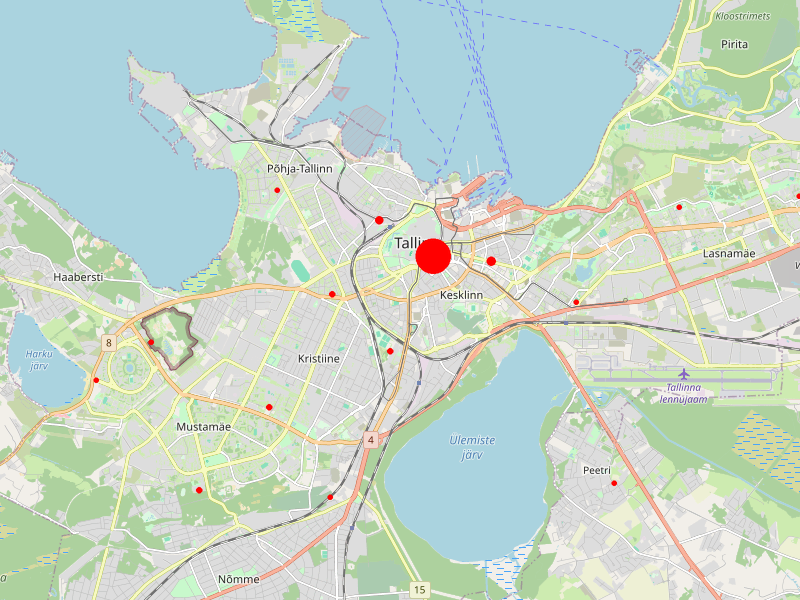

In [32]:
image

## 5. Results and Future Work


* My script takes the current day, time, and location information of the driver, and then outputs a score for each cluster based on predictions from the Random Forest Regressor model. This score also considers the Haversine distance between the driver's current location and the cluster centers.

* The script suggests clusters to drivers based on a probability score, which helps distribute drivers across different clusters and reduces the likelihood of multiple drivers being directed to the same area. The suggestion also accounts for the distance to cluster centers, decreasing the score for clusters that are too far from the driver's current location.
- To enhance the model predictions, these features can be also helpful:
  - Seasonality (summer, winter) can be captured if I had data for other months as well
  - Instead of using the Haversine distance, roads and traffic distance can also be used
  - Weather information
  - Holidays in Tallinn, Estonia
  - Information and issues with the public transportation
    

* To match the demand dynamically, the number of drivers that are available in that are (supply side) should also be considered. My method can be enhanced after knowing the driver information and the drivers can be directed tthe areas accordingly.

* A Docker containerized MLflow can be used to track the model’s performance over time. The application can interact with the model via a REST API, sending data and receiving predictions in real-time.

* The recommendations of my model can be sent to the drivers using Push Notifications. So that the drivers can plan beforehand.
  
* To validate the effectiveness of this methodology, A/B testing can be conducted to compare the proposed model with the current system. Metrics such as customer satisfaction and overall demand coverage should be analyzed to assess improvements and ensure that the new approach delivers better results.